In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy.linalg as lin
from multiprocessing import Pool

In [9]:
#originally I try +/- 500m but i think its better if i try smaller radius
# x = np.arange(-500, 500, 10)
# y = np.arange(0, 400, 10)
# z = np.arange(-500, 500, 10)
# x.shape

# x = np.arange(-200, 200, 1)
# y = np.arange(0, 400, 1)
# z = np.arange(-200, 200, 1)
# xx, yy, zz = np.meshgrid(x, y, z)

x = np.arange(-100, 100, 10)
y = np.arange(0, 400, 10)
z = np.arange(-100, 100, 10)
xx, yy, zz = np.meshgrid(x, y, z)

# x,z are horizontal plane
# y is depth

# calculates distance from every grid point to every hydrophone location
dx_h3 = np.sqrt(xx**2 + (yy-170)**2 + zz**2)
dx_h4 = np.sqrt(xx**2 + (yy-240)**2 + zz**2)
dx_h5 = np.sqrt(xx**2 + (yy-310)**2 + zz**2)
dx_h6 = np.sqrt(xx**2 + (yy-380)**2 + zz**2)

# set velocity model to be the same everywhere
vp = np.zeros_like(xx) + 6000

# calculate perfect travel times to each hydrophone
t_h3 = dx_h3/vp
t_h4 = dx_h4/vp
t_h5 = dx_h5/vp
t_h6 = dx_h6/vp

In [10]:
hydrophones = ['h3', 'h4', 'h5', 'h6']
true_arrivals = [0.137-0.086, 0.086-0.086, 0.111-0.086, 0.153-0.086]
true_arrivals

[0.05100000000000002, 0.0, 0.02500000000000001, 0.067]

In [11]:
# h6 0.153
# h5 0.111
# h4 first 0.086
# h3 0.137
# starttime 2019-05-21T08:05:17.933000Z

In [12]:
event_time = pd.to_datetime('2019-05-21 08:05:17.933')

true_arrivals = [0.137, 0.086, 0.111, 0.153]

event_times = []
for t in true_arrivals:
    et = event_time - event_time.floor('H') + pd.Timedelta(t*1e9)
    event_times.append(et.seconds + et.microseconds*1e-6)
    
# event_time - event_time.floor('H') + pd.Timedelta(0.137e9)
# event_times[0].seconds + event_times[0].microseconds*1e-6
event_times

[318.07, 318.019, 318.044, 318.086]

In [13]:
xx.shape

(40, 20, 20)

In [15]:
# i = 20
# j = 20
# k = 20

# t_h3[i, j, k]

In [17]:
# theoretical_arrivals = [
#     t_h3[i, j, k]
#     ,t_h4[i, j, k]
#     ,t_h5[i, j, k]
#     ,t_h6[i, j, k]
# ]
# theoretical_arrivals

In [18]:
# t_h3.shape

In [31]:
event_time = pd.to_datetime('2019-05-21 08:05:17.933')

true_arrivals = [0.137, 0.086, 0.111, 0.153]

event_times = []
for t in true_arrivals:
    et = event_time - event_time.floor('H') + pd.Timedelta(t*1e9)
    event_times.append(et.seconds + et.microseconds*1e-6)
    
# event_time - event_time.floor('H') + pd.Timedelta(0.137e9)
# event_times[0].seconds + event_times[0].microseconds*1e-6
event_times

i = 10
j = 10
k = 15
theoretical_arrivals = [
    t_h3[i, j, k]
    ,t_h4[i, j, k]
    ,t_h5[i, j, k]
    ,t_h6[i, j, k]
]

# per grid point
good_picks = np.diag(np.array([1, 1, 1, 1])) #this is different from gvec because it can have zeros whne there is no pick

dvec = np.vstack(np.array(event_times)) - np.vstack(np.array(theoretical_arrivals))

wmat = np.vstack(0.1*good_picks)
gvec = np.ones_like(good_picks).astype(float)

t0_top = gvec.transpose().dot(wmat).dot(gvec)
t0_bottom = gvec.dot(wmat).dot(dvec)

# linalg returns x, residuals, rank, s, we only want x, the solution
t0 = np.linalg.lstsq(t0_top, t0_bottom)[0]

evec = np.zeros_like(good_picks)
evec = dvec - gvec.dot(t0)
np.sqrt(evec.transpose().dot(wmat).dot(evec) / np.sum(np.diag(wmat)))[0][0]

[1, 2]
[3, 4]

[5, 6]
[7, 8]



/tmp/ipykernel_31211/746220066.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  t0 = np.linalg.lstsq(t0_top, t0_bottom)[0]


0.02427680179319597

In [25]:
event_time - event_time.floor('H') + pd.Timedelta(t*1e9)

Timedelta('0 days 00:05:18.086000')

In [20]:
event_time = pd.to_datetime('2019-05-21 08:05:17.933')

true_arrivals = [0.137, 0.086, 0.111, 0.153]

event_times = []
for t in true_arrivals:
    et = event_time - event_time.floor('H') + pd.Timedelta(t*1e9)
    event_times.append(et.seconds + et.microseconds*1e-6)
    
# event_time - event_time.floor('H') + pd.Timedelta(0.137e9)
# event_times[0].seconds + event_times[0].microseconds*1e-6
event_times

i_s = np.arange(0, t_h3.shape[0], 1)
j_s = np.arange(0, t_h3.shape[1], 1)
k_s = np.arange(0, t_h3.shape[2], 1)

rms_cube = np.zeros_like(t_h3)

for i in i_s:
    for j in j_s:
        for k in k_s:
            theoretical_arrivals = [
                t_h3[i, j, k]
                ,t_h4[i, j, k]
                ,t_h5[i, j, k]
                ,t_h6[i, j, k]
            ]

            # per grid point
            good_picks = np.diag(np.array([1, 1, 1, 1])) #this is different from gvec because it can have zeros whne there is no pick
            dvec = np.vstack(np.array(event_times)) - np.vstack(np.array(theoretical_arrivals))
            wmat = np.vstack(0.1*good_picks)
            gvec = np.ones_like(good_picks).astype(float)
            t0_top = gvec.transpose().dot(wmat).dot(gvec)
            t0_bottom = gvec.dot(wmat).dot(dvec)

            # linalg returns x, residuals, rank, s, we only want x, the solution
            t0 = np.linalg.lstsq(t0_top, t0_bottom)[0]

            evec = np.zeros_like(good_picks)
            evec = dvec - gvec.dot(t0)
            rms_cube[i,j,k] = np.sqrt(evec.transpose().dot(wmat).dot(evec) / np.sum(np.diag(wmat)))[0][0]


/tmp/ipykernel_31211/1500801712.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  t0 = np.linalg.lstsq(t0_top, t0_bottom)[0]


array([[490]])

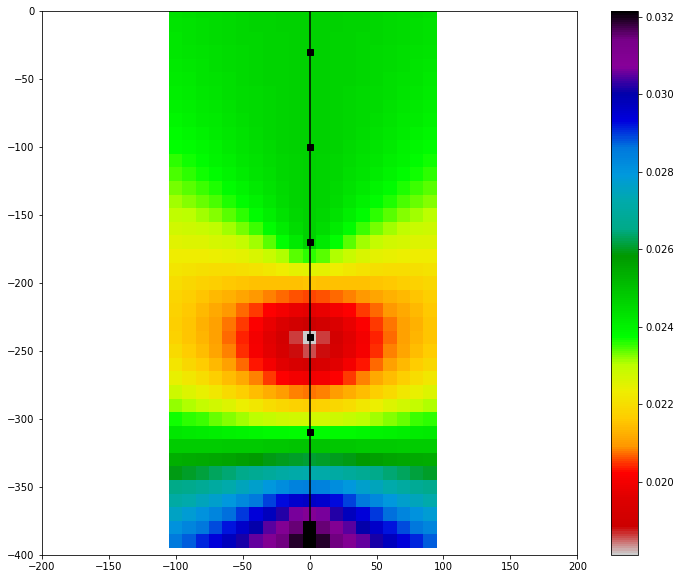

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))

Z = rms_cube[:,10,:].copy().astype(np.float64)
cbar = ax.pcolormesh(x, -y, Z, cmap='nipy_spectral_r',shading='auto')
fig.colorbar(cbar)

hdepths = np.array([-10, 30, 100, 170, 240, 310, 380])
ax.plot(np.zeros_like(hdepths), -hdepths, color='black', marker='s')
ax.set_ylim(-400, 0)
ax.set_xlim(-200, 200)
Z.argmin(keepdims=True)

In [ ]:
# plt.hist(rms_cube.flatten(), bins=100)

In [ ]:
# np.diag(dvec.flatten())

In [ ]:
# g = gvec.copy()
# w = wmat.copy()
# d = np.diag(dvec.flatten()).copy()
# np.matmul(g, w, d)

In [ ]:
# np.matmul(gvec.transpose(), wmat, gvec)

In [ ]:
# a = np.array([[1, 2], [3, 4]])
# b = np.array([[5, 6], [7, 8]])

# print(a)
# print(b)
# print(a*b)
# print(np.matmul(a, b))
# print(a.dot(b))

In [ ]:
# evec = dvec - gvec*t0
# np.sqrt(evec.transpose()*wmat*evec / np.sum(np.diag(wmat)))[0][0]

In [ ]:
# print(np.sqrt(evec.transpose().dot(wmat).dot(evec)/np.sum(np.diag(wmat))))
